In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/My\ Drive/journey-springfield.zip -d springfield

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm.notebook import tqdm
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch

from matplotlib import colors, pyplot as plt
%matplotlib inline

In [ ]:
def oversample(dataset, class_lambda,min_class_size=100):
    classes = np.unique([class_lambda(item) for item in dataset])
    for class_name in classes:
        class_files = [item for item in dataset if class_lambda(item) == class_name]
        class_size = len(class_files)
        while class_size < min_class_size:
            dataset += class_files
            class_files = [item for item in dataset if class_lambda(item) == class_name]
            class_size = len(class_files)
    return dataset

In [ ]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le  _dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
          
            self.transform = transforms.Compose([
                transforms.RandomRotation(15),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Lambda(lambda x: np.array(x.resize((RESCALE_SIZE, RESCALE_SIZE)), dtype='float32') / 255),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Lambda(lambda x: np.array(x.resize((RESCALE_SIZE, RESCALE_SIZE)), dtype='float32') / 255),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
                      
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self, index):
        image = Image.open(self.files[index])
        image.load()
        x = self.transform(image)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

TRAIN_DIR = Path('springfield/train/simpsons_dataset')
TEST_DIR = Path('springfield/testset/testset')

train_val_files = oversample(sorted(list(TRAIN_DIR.rglob('*.jpg'))), lambda x: x.parent.name, min_class_size=150)
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(
    train_val_files, test_size=0.25, 
    stratify=train_val_labels
)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
class CNN(nn.Module):
    def __init__(self, model_name, n_classes, lr=1e-4):
        super().__init__()
        self.lr = lr
        if model_name == 'resnet':
            self.model = models.resnet50(pretrained=True)
            out_features = 2048
            self.model.fc = nn.Sequential(
                nn.Linear(out_features, 1024),
                nn.ReLU(inplace=True),
                nn.Dropout(),

                nn.Linear(1024, 512),
                nn.ReLU(inplace=True),
                nn.Dropout(),

                nn.Linear(512, n_classes)
            )
            unfreeze_layers = ['layer3', 'layer4', 'avgpool', 'fc']
            for name, child in self.model.named_children():
                if name in unfreeze_layers:
                    for param in child.parameters():
                        param.requires_grad = True
                else:
                    for param in child.parameters():
                        param.requires_grad = False
        elif model_name == 'vgg':
            self.model = models.vgg16_bn(pretrained=True)
            out_features = 1000
            self.model.classifier = nn.Sequential(
                nn.Linear(out_features, 1024),
                nn.ReLU(inplace=True),
                nn.Dropout(),

                nn.Linear(1024, 512),
                nn.ReLU(inplace=True),
                nn.Dropout(),

                nn.Linear(512, n_classes)
            )
            unfreeze_layers = ['avgpool', 'classifier']
            for name, child in self.model.named_children():
                if name in unfreeze_layers:
                    for param in child.parameters():
                        param.requires_grad = True
                else:
                    for param in child.parameters():
                        param.requires_grad = False
            for param in self.model.features[:-4].parameters():
                param.requires_grad = False
        else:
            raise Exception
        
    def forward(self, x):
        result = self.model(x)
        return result
    
    def fit_epoch(self, train_loader, criterion, optimizer):
        running_loss = 0.0
        running_corrects = 0
        processed_data = 0
      
        for inputs, labels in train_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            optimizer.zero_grad()

            outputs = self(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            preds = torch.argmax(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            processed_data += inputs.size(0)
                  
        train_loss = running_loss / processed_data
        train_acc = running_corrects.cpu().numpy() / processed_data
        return train_loss, train_acc

    def eval_epoch(self, val_loader, criterion):
        self.eval()
        running_loss = 0.0
        running_corrects = 0
        processed_size = 0

        for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            with torch.set_grad_enabled(False):
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                preds = torch.argmax(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            processed_size += inputs.size(0)
        val_loss = running_loss / processed_size
        val_acc = running_corrects.double() / processed_size
        return val_loss, val_acc


    def train_model(self, train_files, val_files, epochs, batch_size):
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        history = []
        log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
        opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, self.model.parameters()), lr=self.lr, amsgrad=True)
        criterion = nn.CrossEntropyLoss()
        for epoch in tqdm(range(epochs)):
            train_loss, train_acc = self.fit_epoch(train_loader, criterion, opt)            
            val_loss, val_acc = self.eval_epoch(val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            print(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
                
        return history


    def predict(self, test_loader):
        with torch.no_grad():
            logits = []
        
            for inputs in test_loader:
                inputs = inputs.to(DEVICE)
                self.eval()
                outputs = self(inputs).cpu()
                logits.append(outputs)
                
        probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
        return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
resnet = CNN(
    model_name='resnet',
    n_classes=n_classes,
).to(DEVICE)

model_list = [
    {
        'name': 'resnet',
        'model': resnet,
        'epochs': 10,
        'history': [],
    }
]

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [ ]:
for i, model_dict in enumerate(model_list):
    model = model_dict['model']
    epochs = model_dict['epochs']
    name = model_dict['name']
    model_dict['history'] += model.train_model(
        train_dataset,
        val_dataset,
        epochs=epochs,
        batch_size=64,
    )
    torch.save(model, name+'.model')


Epoch 001 train_loss: 1.8102 val_loss 0.7896 train_acc 0.5455 val_acc 0.7692

Epoch 002 train_loss: 0.5188 val_loss 0.4374 train_acc 0.8590 val_acc 0.8898

Epoch 003 train_loss: 0.1935 val_loss 0.1944 train_acc 0.9496 val_acc 0.9520

Epoch 004 train_loss: 0.1362 val_loss 0.2070 train_acc 0.9634 val_acc 0.9440

Epoch 005 train_loss: 0.1009 val_loss 0.1623 train_acc 0.9738 val_acc 0.9610

Epoch 006 train_loss: 0.0901 val_loss 0.1631 train_acc 0.9768 val_acc 0.9641

Epoch 007 train_loss: 0.0743 val_loss 0.0951 train_acc 0.9808 val_acc 0.9800

Epoch 008 train_loss: 0.0614 val_loss 0.1142 train_acc 0.9840 val_acc 0.9754

Epoch 009 train_loss: 0.0544 val_loss 0.1526 train_acc 0.9868 val_acc 0.9641

Epoch 010 train_loss: 0.0459 val_loss 0.1016 train_acc 0.9882 val_acc 0.9766



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


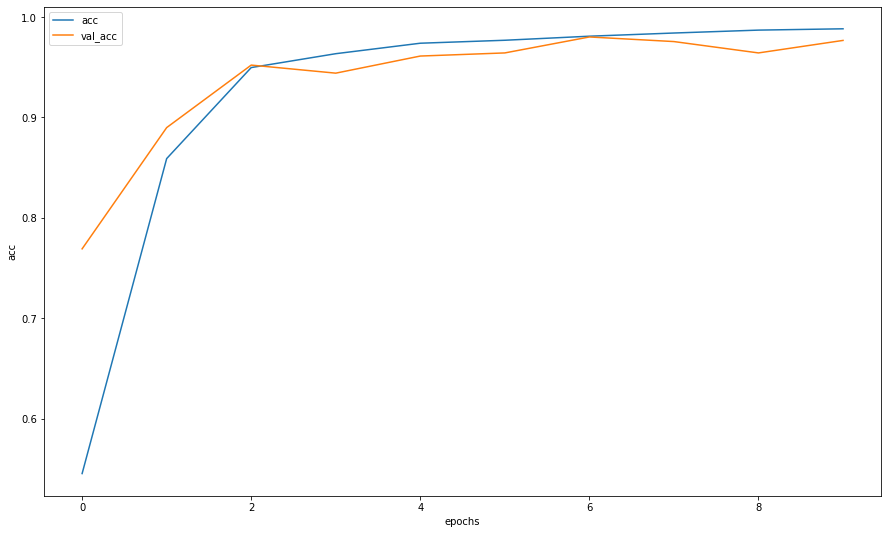

In [ ]:
for i, model_dict in enumerate(model_list):
    loss, acc, val_loss, val_acc = zip(*model_dict['history'])
    plt.figure(figsize=(15, 9))
    plt.plot(acc, label="acc")
    plt.plot(val_acc, label="val_acc")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("acc")
    plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(resnet, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = resnet.predict(imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

1.0

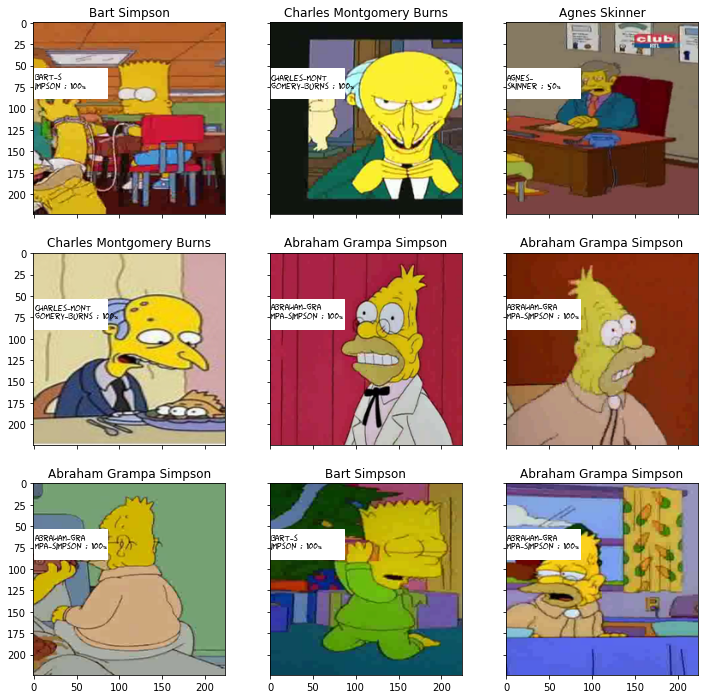

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(resnet, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = resnet.predict(test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

my_submit.to_csv('resnet50.csv', index=False)